# Best SIP Date with Highest Returns

This is a simple analysis to find out which SIP date had yielded highest returns for Parag Parikh Long Term Equity Fund - Direct Plan - Growth. The standard SIP dates considered are 1st, 5th, 10th, 15th, 20th and 25th of calendar month. The following analysis is illustrated using python programming language. If you are not a programmer, still could read this analysis by simply skipping the awkward looking text inside grey colored boxes which software engineers call it as code. You can download the dataset from this link https://drive.google.com/file/d/148DVNZ2_q2xOhrSbagPdy4N8li-QPPfg/view?usp=sharing

## Load Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from babel.numbers import format_currency
from datetime import datetime
from IPython.display import display, HTML

## Initial Setup

The following is the initial setup made for the analysis.
    
* An SIP amount of ₹10,000

* Standard SIP dates considered are 1st, 5th, 10th, 15th, 20th and 25th of a calendar month

* Number of years to calculate retruns for. *Maximum number of years to which the returns can be calculated is limited back to the year 1993. Because, the Private sector mutual funds started in the year 1993.*
* Scheme: *Parag Parikh Long Term Equity Fund - Direct Plan - Growth*
* Scheme Code: 122639

In [2]:
sip = 5000
standardSIPDates = [1,5,10,15,20,25]
maxYears = datetime.now().year - 1993 # private sector mutual funds in India started in the year 1993
years = [1, 3, 5, 10, maxYears]
#years = [1, 2, maxYears]

schemeName='Franklin India Prima Fund-Growth'
fpath =r'C:\Users\navulep\AnacondaProjects\MF\data\gold\{}.txt'.format(schemeName)
schemeCode = 100473
recentNAV = None

## Load Data
Load the data into a pandas data frame

In [3]:
import requests
def loadDataFromWeb():
    #make web request
    from datetime import datetime
    url = "http://portal.amfiindia.com/DownloadNAVHistoryReport_Po.aspx"

    querystring = {"mf":"64","tp":"1","frmdt":"01-Jan-1979","todt":datetime.today().strftime('%d-%b-%Y')}

    headers = {
        'cache-control': "no-cache"
        }

    response = requests.request("GET", url, headers=headers, params=querystring)
    
    #build dataframe
    cols = []
    lst = []
    for cnt, line in enumerate(response.text.splitlines()):
        line = line.strip()
        props = line.split(';')
        if len(props) > 1 :
            #process
            if cnt == 0:
                cols =  props
            elif cnt == 1:
                print(props)
            else:
                lst.append(props)
    response = None
    df = pd.DataFrame(lst, columns = cols)
    return df

def loadDataFromFile(filepath):
    cols = []
    lst = []
    with open(filepath) as fp:
        for cnt, line in enumerate(fp):
            line = line.strip()
            props = line.split(';')
            if len(props) > 1 :
                #process
                if cnt == 0:
                    cols =  props
                elif cnt == 1:
                    print(props)
                else:
                    lst.append(props)

    df = pd.DataFrame(lst, columns = cols)
    return df

def loadData(filepath):
    df = pd.read_csv(filepath,sep=';')
    return df

## Data wrangling
### Handling Missing NAV
As the NAV is not available on weekends and holidays, the back fill approach is follwed. This means, the NAVs for weekends are back filled with that of succeeding Monday's NAVs. Other missing days' Nav such as holidays are filled with NAV of the next available day.

By default all the data loaded into a pandas dataframe will be in string format. To smoothen the data access and analysis easier, cast the 'Date' column to DateTime and 'Net Asset Value' column to float.

Also, control the range of NAVs to be processed by a numeric variable 'yearsToConsider'. This is to calculate the seperate of highest SIP returns yielding date for tenures of 1 year, 3 years, 5 years and so on. For example, set yearsToConsider value to 3 to know the best SIP date that had yielded the highest returns if the SIP had been initiated back 3 years from today (or from latest available NAV date in the dataset).

In [4]:
def preprocessing(df, schemeCode, yearsToConsider):
    df['Date'] =  pd.to_datetime(df['Date'], format='%d-%b-%Y')
    df['Net Asset Value'] = pd.to_numeric(df['Net Asset Value'], errors='coerce')
    df1 = df[df['Scheme Code']==schemeCode][['Net Asset Value','Date']]
    #fill navs on weekends with the monday's nav. Other missing days' Nav such as holidays will be filled with the nav for the next available date
    df1 = df1.set_index('Date').asfreq('d', method='bfill')
    df1 = df1[df1.index.max()-np.timedelta64(yearsToConsider,'Y'):df1.index.max()]
    return df1

In [5]:
#Absolute Return
def AbsReturn(L,F):
    absRet = round(100*(L-F)/F, 3)
    return absRet

In [6]:
#Simple Annualised Return
def SAR(L,F,Terms):
    absRet = round((AbsReturn(L,F)/100), 3)
    #print("terms for ABSRet {}".format(absRet))
    noOfDays = Terms * 30
    sar = ((1 + absRet) ** (365/ noOfDays)) - 1
    return round(sar, 3) * 100

In [7]:
import scipy.optimize

def XNPV(rate, values, dates):
    if rate <= -1.0:
        return float('inf')
    d0 = dates[0]    # or min(dates)
    return sum([ vi / (1.0 + rate)**((di - d0).days / 365.0) for vi, di in zip(values, dates)])

def XIRR(values, dates):
    try:
        return round(scipy.optimize.newton(lambda r: XNPV(r, values, dates), 0.0)*100, 3)
    except RuntimeError:   
        return (scipy.optimize.brentq(lambda r: XNPV(r, values, dates), -1.0, 1e10)*100, 3)

## Basic SIP Calculation Methods
The returns by date invested in sip are calculated for each calendar date starting from 1 to 30. Calculation for Date 31 is excluded for brevity.
### SIP Amount Consideration
For an SIP payment, consider the fixed amount for each term, lets say ₹5,000. However, changing this amount will not affect the calculation of returns for a given mutual fund data.

### Calculation of Units Alloted per SIP Term
The units alloted per SIP term is the ratio of SIP amount to the NAV of mutual fund on the date of allotment.
> unitsForCurrTerm = round(sip/nav, 4)

*As per the SEBI guidelines, The mutual fund units alloted are calculated upto 4 decimals places.*

### Total number of units alloted for SIP till date
The total units alloted for a particular SIP date is the sum of units alloted across all the SIP terms falling in the duration of years considered.
>totalUnits = round(totalUnits + unitsForCurrTerm,4)

### Total Amount Invested in SIP till date
The total amount invested in SIP till date is just the product of SIP amount and number of terms SIP is paid.
>amtInvested = round(terms * sip, 3)


### Average NAV across all SIP payments
The average NAV across all SIP payments for a mutual fund is the ratio of total amount invested to the total number of units alloted till date.
>avgNav = round(amtInvested / totalUnits, 4)

### Absolute Return
Absolute return is calculated by the product of the Total number of units and latest NAV of the mutual fund.
>returns = round(totalUnits * latestNav, 3)

*As per the SEBI guidelines, the mutual fund redemption amount will be calculate up to 3 decimal places.*

### Simple Annualised Return
Simple Annualised Returns are calculated when the total number of SIP terms of a mutual fund investment is exactly equals to 12. The formula for Simple annualised return is

> $Simple Average Return = (1 + Absolute Return)^\frac{365}{Total No. of Days} - 1$


### XIRR Calculation
XIRR is an acronym for eXtended Internal Rate of Return. This Annualization technique, XIRR in case of SIP is calculated only when the total number of SIP terms are more than 12. XIRR uses Newton Raphson method.

Following table describes when to use which annualization technique.

| Months | Calcuation  |
| :------: | :----------: |
| <12 | Absolute Return | 
| 12 | Simple Annualised Return | 
| >12 | XIRR | 


### Terms
Terms is the total count of SIP payments made in the duration of years selected. As we are calculating the returns for same date of each month, the term count in this analysis is referred as the number of months the SIP was invested.

## Best SIP Date calculation approach
For each calendar date falling in the duration of years considered, the units alloted to the investor are calculated by dividing the SIP amount by the nav of that particular date. Likewise, the total units alloted for a particular SIP date is the sum of units alloted across all the SIP terms falling in the duration of years considered. 

Now, calculate the total amount invested, absolute returns, average NAV and XIRR as per the basic SIP calculation methods mentioned above. Now you will have all these metrics for SIP dates 1 to 30. Filter the results based on the the standard SIP dates defined. Filtering could be made optional if you are interested in looking across all the calendar dates 1 through 30. Notice the higest return yielding SIP date by sorting the XIRR in the descending order.

### Example
Consider a calendar date say 3rd of every month. Suppose 3 year duration is considered. Add up the units alloted to the mutual fund investor for 3rd date of every month (weekends, holidays falling on 3rd will have back filled NAV). Repeat this for all the calendar days 1 to 30. Now consider the standard sip dates defined and look at the highest return yielding SIP date among 1, 5, 10, 15, 20 and 25.

In [8]:
def ReturnsByDateInvestedInSIP(data, sip=5000, filterStandardSIPDates = True):
    latestNav = data.loc[data.index == data.index.max(),'Net Asset Value'].iloc[0]
    firstNav = data.loc[data.index == data.index.min(),'Net Asset Value'].iloc[0]
    recentNavDate = data.index.max()
    
    #for dates 1 through 30 collect units allotted and returns gained
    sipdate_units = []
    for day in range(1,31):
        totalUnits = 0
        dfvar = data[data.index.day == day]

        terms = dfvar.shape[0]
        for nav in dfvar['Net Asset Value']:
            unitsForCurrTerm = round(sip/nav, 4)
            totalUnits = round(totalUnits + unitsForCurrTerm, 4)
        
        amtInvested = round(terms * sip, 3)
        returns = round(totalUnits * latestNav, 3)
        
        avgNav = round(amtInvested / totalUnits, 4)
        
        xirr = 0
        if terms < 12 :
            #xirr = AbsReturn(returns,amtInvested)
            xirr = AbsReturn(latestNav,avgNav)
        elif terms == 12 :
            xirr = SAR(latestNav, avgNav, terms)
        elif terms > 12 :
            ## START XIRR
            xirrdataset=[]
            for sipdate in dfvar.index.values:
                xirrdataset.append({'Date':sipdate,'Cashflow': float(-sip)})
            # Finally add final cashflow date
            xirrdataset.append({'Date':recentNavDate,'Cashflow': returns})
            xirrdataset = pd.DataFrame(xirrdataset,columns=('Date','Cashflow'))
            #print(xirrdataset)
            xirr = XIRR(xirrdataset['Cashflow'], xirrdataset['Date'])
            ## END XIRR
        sipdate_units.append({'SIP Date': day,
                              'Average Nav': avgNav,
                              'Units': totalUnits,
                              'Terms': terms, 
                              'Amt Invested': amtInvested,
                              'Absolute Returns': returns,
                              'XIRR %': xirr
                             })
    rets = pd.DataFrame(sipdate_units, columns=('SIP Date','Average Nav','Units', 'Terms', 'Amt Invested', 'Absolute Returns', 'XIRR %'))
    rets.index += 1 # some novice pandas expertiese ^_^
    if filterStandardSIPDates:
        rets = rets[rets['SIP Date'].isin(standardSIPDates)]
    rets = rets.sort_values('XIRR %',ascending =False)
    return rets

## Data Visualisation
The histogram shows SIP dates on X-axis and corresponding returns on Y axis.

In [9]:
def ShowPlot(d, toDate, fromDate):
    best = d[d['XIRR %']==d['XIRR %'].max()]
    bestSIPDate = best['SIP Date'].iloc[0]
    bestReturn = best['XIRR %'].iloc[0]
    yearsObserved = round(d['Terms'].iloc[0]/12, 2)
    yearsObserved= "{0}".format(str(yearsObserved if yearsObserved % 1 else int(yearsObserved)))
    plt.figure(num=None, figsize=(10, 6), dpi=150)
    plt.hist(d['SIP Date'], weights=d['XIRR %'], facecolor= 'r' if d['XIRR %'].mean() < 0 else 'g', bins = 25)
    plt.xlabel('SIP Date')
    plt.ylabel('XIRR %')
    plt.title(schemeName)
    legend1 = 'Best SIP Date: {} \nYear(s) Observed: {} years \nAbsolute returns: {}%\n'
    legend2 = 'Dates Considered\nFrom: {} \nTo: {}\n'
    if d['XIRR %'].mean() < 0 :
        plt.text(0, .07, legend1.format(bestSIPDate, yearsObserved, bestReturn), fontsize=9)
        plt.text(21, .07, legend2.format(fromDate,toDate), fontsize=9)
    elif any(x < 0 for x in d['XIRR %']) and any(x>0 for x in d['XIRR %']):
        plt.text(1, .003, legend1.format(bestSIPDate, yearsObserved, bestReturn), fontsize=9)
        plt.text(20.5, .003, legend2.format(fromDate,toDate), fontsize=9)
    else:
        plt.text(1, 2, legend1.format(bestSIPDate, yearsObserved, bestReturn), fontsize=9)
        plt.text(20.5, 2, legend2.format(fromDate,toDate), fontsize=9)
    plt.annotate('The past {} year(s) of observations indicate that, having SIP date set to {} of every month would have given the\n highest XIRR of {}%'.format(yearsObserved,bestSIPDate,bestReturn),
                 (0,0), (0, -35), 
                 xycoords='axes fraction', 
                 textcoords='offset points', va='top')
    plt.annotate('www.MFRepublic.com', (0,0), (250, 150), 
             xycoords='axes fraction',fontsize=20,
             textcoords='offset points', ha='center', va='bottom', alpha = 0.25)
    plt.show()
    plt.close()

In [10]:
def Summary(returnsByYear):
    summary = []
    display(HTML('<h2>Summary</h2>'))
    display(HTML('<h4>Best SIP Date for {}</h4>'.format(schemeName)))
    
    for key, value in returnsByYear.items():
        summary.append({'Investment Made':'{} Year(s) Ago'.format(key), 'Best SIP Date':value['SIP Date'].iloc[0], 'XIRR %': value['XIRR %'].iloc[0]})

    summary = pd.DataFrame(summary, columns=('Investment Made', 'Best SIP Date', 'XIRR %'))
    display(HTML(summary.to_html(index=False)))
    display(HTML('<p><small><i>*Returns above 1 year are annualized</i><small></p>'))
    summarytext = '<p>If you have started an SIP of {} in the scheme {} : <ul>'.format(format_currency(sip, 'INR', locale = 'en_IN'),schemeName)
    for key, value in returnsByYear.items():
        sipDate = value['SIP Date'].iloc[0]
        thORst = 'st' if sipDate == 1 else 'th'
        summarytext +='<li>{} year(s) ago on every {}{} of a month, then it would have yielded highest XIRR of {}% than they would have yielded on any other SIP initiation date.</li>'.format(key, sipDate, thORst, value['XIRR %'].iloc[0])
    summarytext +='</ul></p>'
    summarytext += '<p>Best SIP date for {} is {} of every month which has generated higher annualized returns.</p>'.format(schemeName, summary['Best SIP Date'].mode().iloc[0])
    summarytext += '<p><i><strong>Disclaimer:</strong> All analysis is based on the past performances. And this may not guarantee future returns. Please read the mutual fund documents carefully before investing.</i></p>'

    display(HTML(summarytext))

In [11]:
def Report(df,isFilterStandardSIPDates):
    returnsByYear={}
    for yr in years:
        df1 = preprocessing(df, schemeCode,yr)
        if( df1.index.max().day == df1.index.min().day):
            df1 =df1[df1.index!=df1.index.min()]
        latestNav = df1.loc[df1.index == df1.index.max(),'Net Asset Value'].iloc[0]
        firstNav = df1.loc[df1.index == df1.index.min(),'Net Asset Value'].iloc[0]
        fromDate = df1.index.min().strftime('%d-%b-%Y')
        toDate = df1.index.max().strftime('%d-%b-%Y')
        dxirr = ReturnsByDateInvestedInSIP(df1,sip,isFilterStandardSIPDates)
        
        #best xirr
        best = dxirr[dxirr['XIRR %']==dxirr['XIRR %'].max()]
        bestSIPDate = best['SIP Date'].iloc[0]
        bestReturn = best['XIRR %'].iloc[0]
        absReturnsValue = best['Absolute Returns'].iloc[0]
        yearsObserved = round(dxirr['Terms'].iloc[0]/12, 2)
        yearsObserved= "{0}".format(str(yearsObserved if yearsObserved % 1 else int(yearsObserved)))
        legend1 = '<strong>Scheme:</strong> {}<br><strong>Scheme Code:</strong> {}<br><strong>Best SIP Date:</strong> {} <br><strong>Years Observed:</strong> {} year(s) <br><strong>XIRR:</strong> {}%<br>'.format(schemeName, schemeCode, bestSIPDate, yearsObserved, bestReturn)
        legend2 = '<strong>Dates Considered</strong><br>From: {} <br>To: {}<br>'.format(fromDate,toDate)
        allOrStandardDates = '1st, 5th, 10th, 15th, 20th and 25th' if isFilterStandardSIPDates else 'all the 30'
        returnsByYear[str(yearsObserved)] = dxirr
        display(HTML('<h2>Returns for {} if the SIP was started {} year(s) ago</h2>'.format(schemeName, yearsObserved)))
        #Show plot
        if isFilterStandardSIPDates:
            ShowPlot(dxirr, toDate, fromDate)
            
        display(HTML(legend1))
        display(HTML(legend2))
        display(HTML(dxirr.to_html(index=False)))
        display(HTML('<p><small><i>*Returns above 1 year are annualized</i><small></p>'))
        display(HTML('<p>The past {} years of observations indicate that, having SIP date set to {} of every month would have given the\n highest XIRR of {}%</p>'.format(yearsObserved,bestSIPDate,bestReturn)))
        display(HTML('<p>An SIP of {} scheduled {} year(s) ago on every month\'s {} would have become {} now.</p>'.format(
            format_currency(sip, 'INR', locale = 'en_IN'),
            yearsObserved,
            bestSIPDate,
            format_currency(absReturnsValue, 'INR', locale = 'en_IN'))))
    return returnsByYear

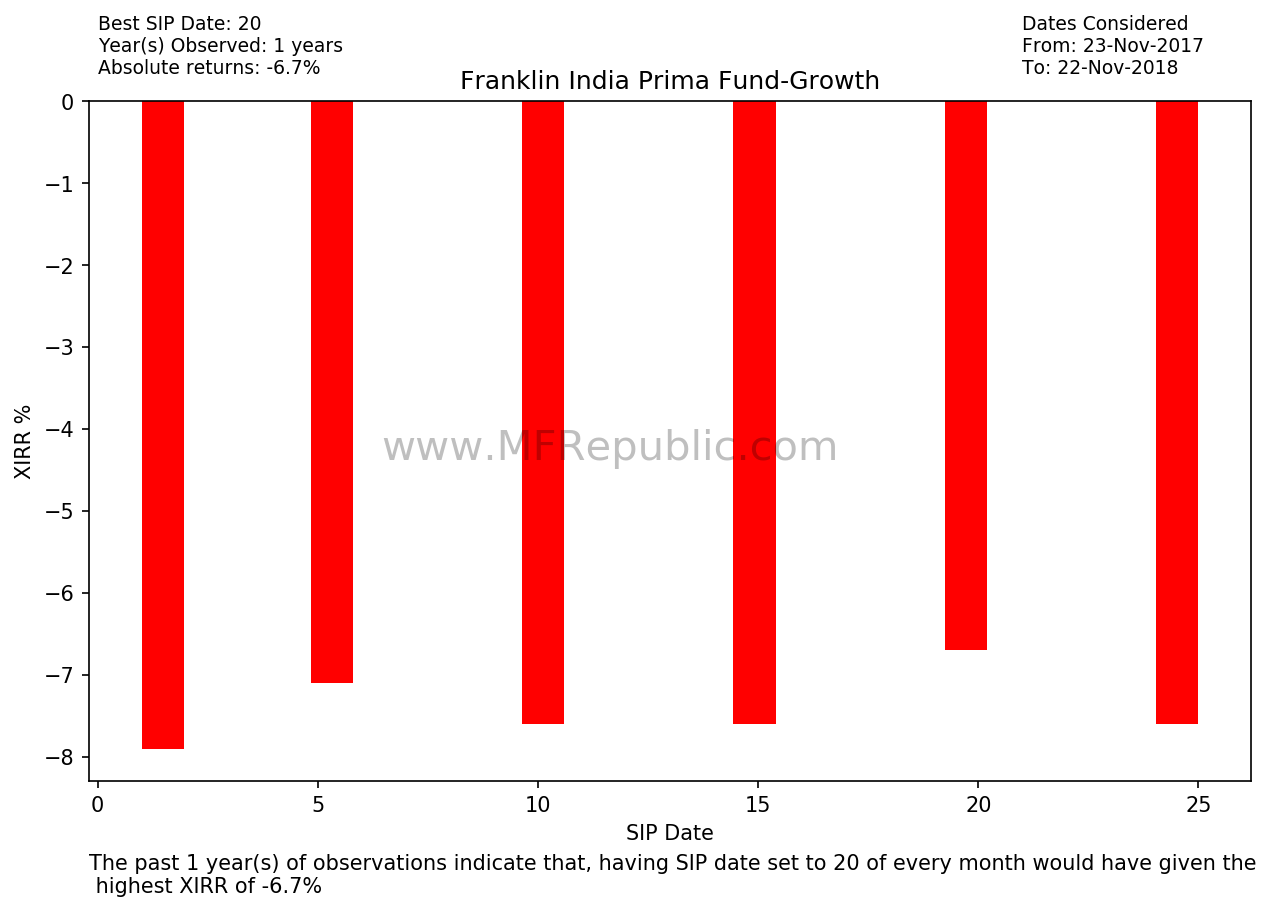

SIP Date,Average Nav,Units,Terms,Amt Invested,Absolute Returns,XIRR %
20,953.5661,62.9217,12,60000,56020.983,-6.7
5,957.6985,62.6502,12,60000,55779.259,-7.1
10,962.5890,62.3319,12,60000,55495.867,-7.6
15,962.0457,62.3671,12,60000,55527.207,-7.6
25,962.5457,62.3347,12,60000,55498.360,-7.6
1,965.7279,62.1293,12,60000,55315.486,-7.9


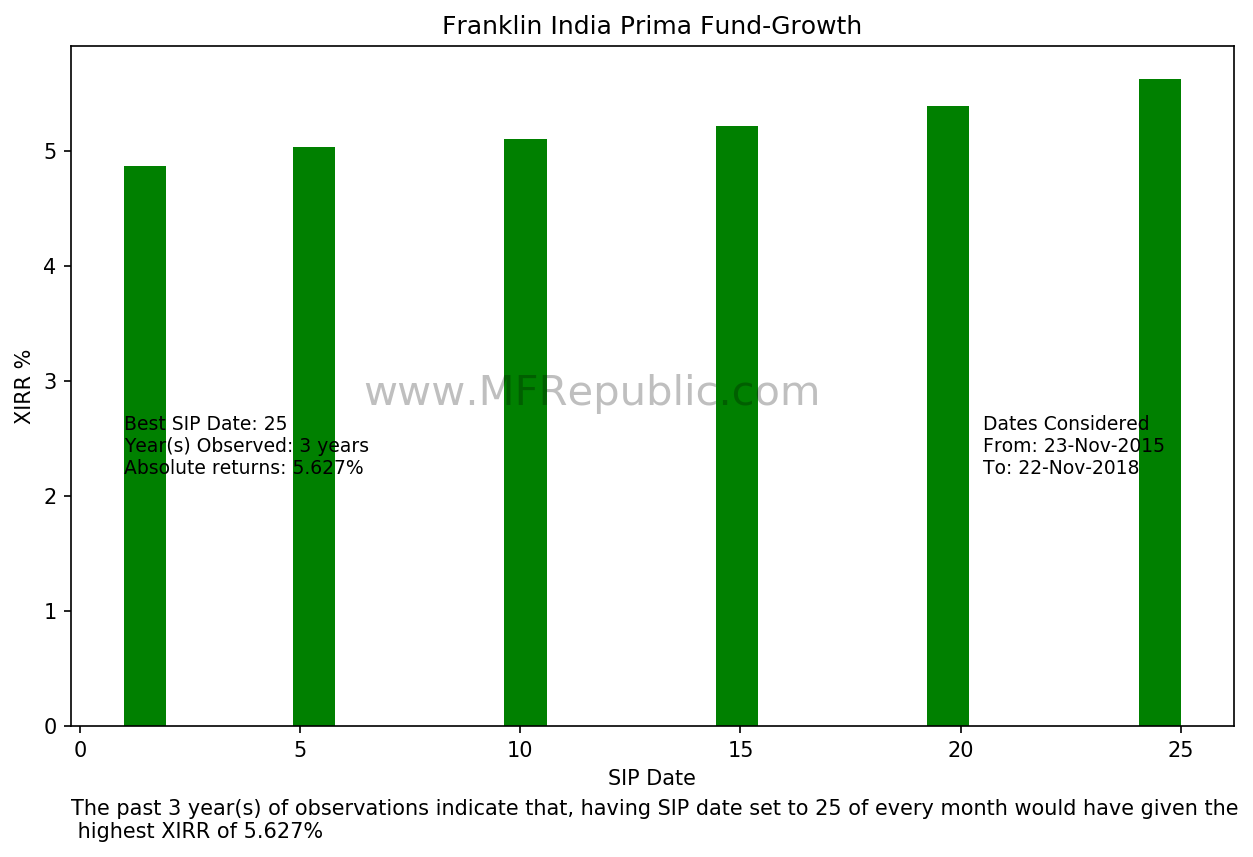

SIP Date,Average Nav,Units,Terms,Amt Invested,Absolute Returns,XIRR %
25,817.6281,220.1490,36,180000,196004.929,5.627
20,823.5710,218.5604,36,180000,194590.553,5.387
15,825.0265,218.1748,36,180000,194247.242,5.215
10,825.8373,217.9606,36,180000,194056.534,5.099
5,826.0666,217.9001,36,180000,194002.669,5.034
1,827.6840,217.4743,36,180000,193623.567,4.866


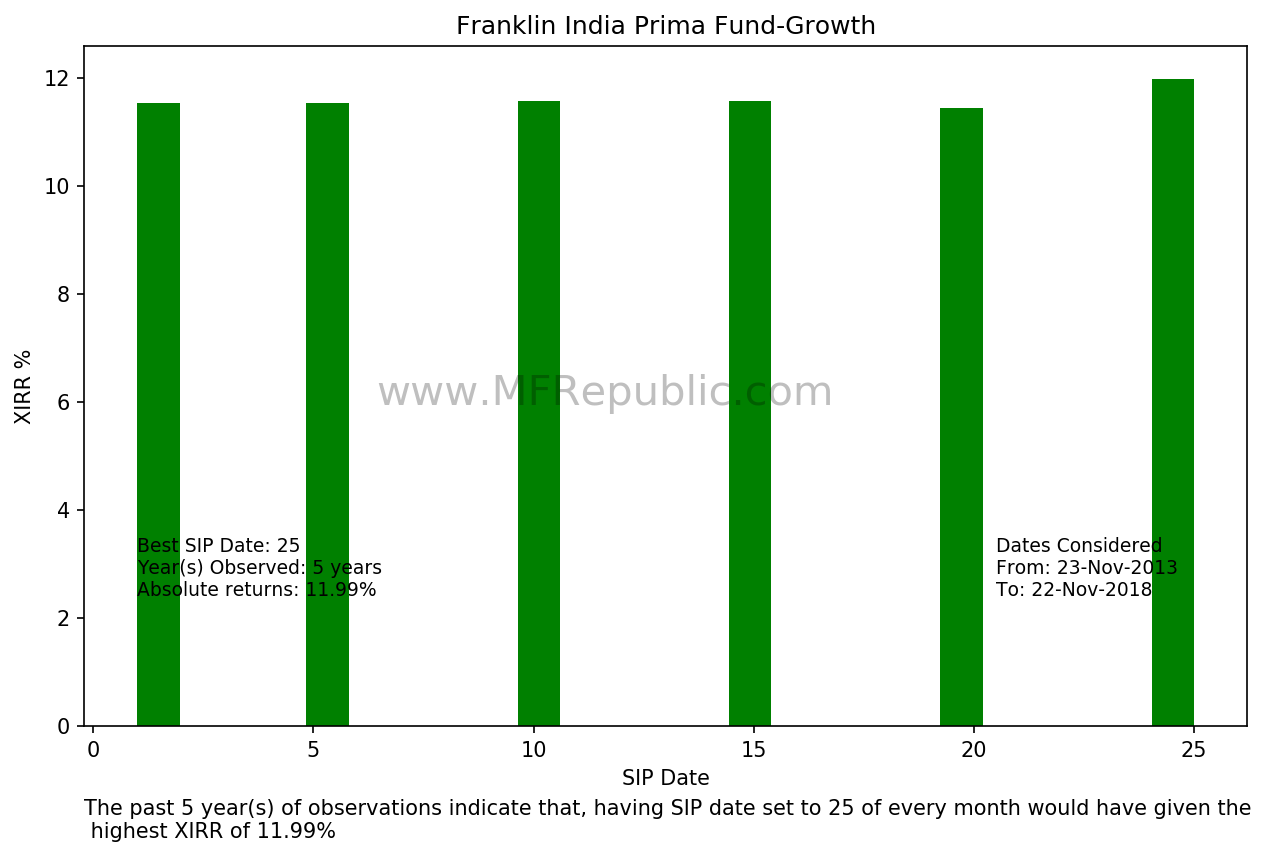

SIP Date,Average Nav,Units,Terms,Amt Invested,Absolute Returns,XIRR %
25,659.2066,455.0925,60,300000,405181.823,11.990
15,669.9597,447.7881,60,300000,398678.507,11.584
10,669.1525,448.3283,60,300000,399159.463,11.572
1,667.7661,449.2591,60,300000,399988.181,11.546
5,668.5936,448.7031,60,300000,399493.158,11.545
20,673.2684,445.5875,60,300000,396719.250,11.442


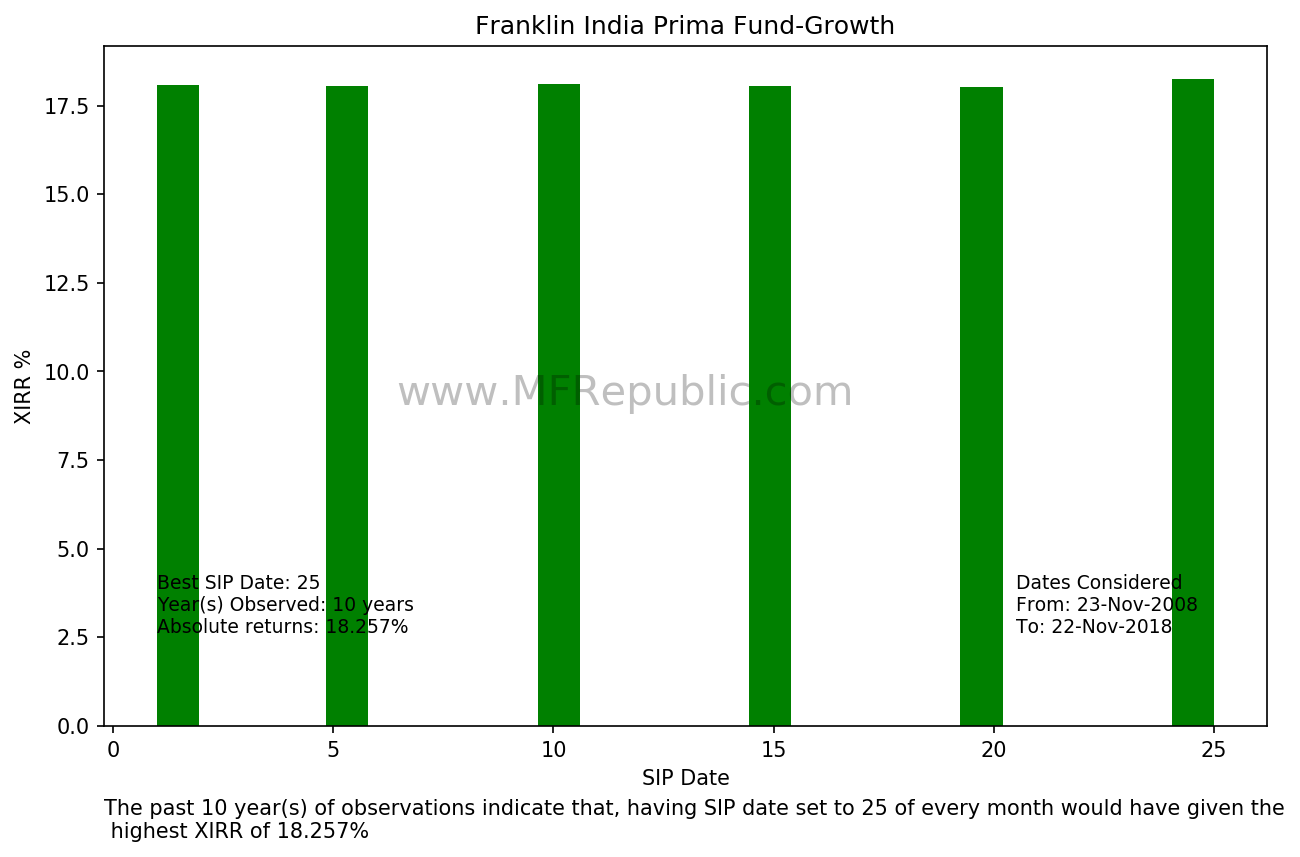

SIP Date,Average Nav,Units,Terms,Amt Invested,Absolute Returns,XIRR %
25,341.0620,1759.2107,120,600000,1566275.424,18.257
10,346.3540,1732.3316,120,600000,1542344.195,18.102
1,345.1453,1738.3984,120,600000,1547745.640,18.091
5,346.4253,1731.9752,120,600000,1542026.882,18.056
15,348.0120,1724.0786,120,600000,1534996.314,18.055
20,349.5199,1716.6407,120,600000,1528374.139,18.017


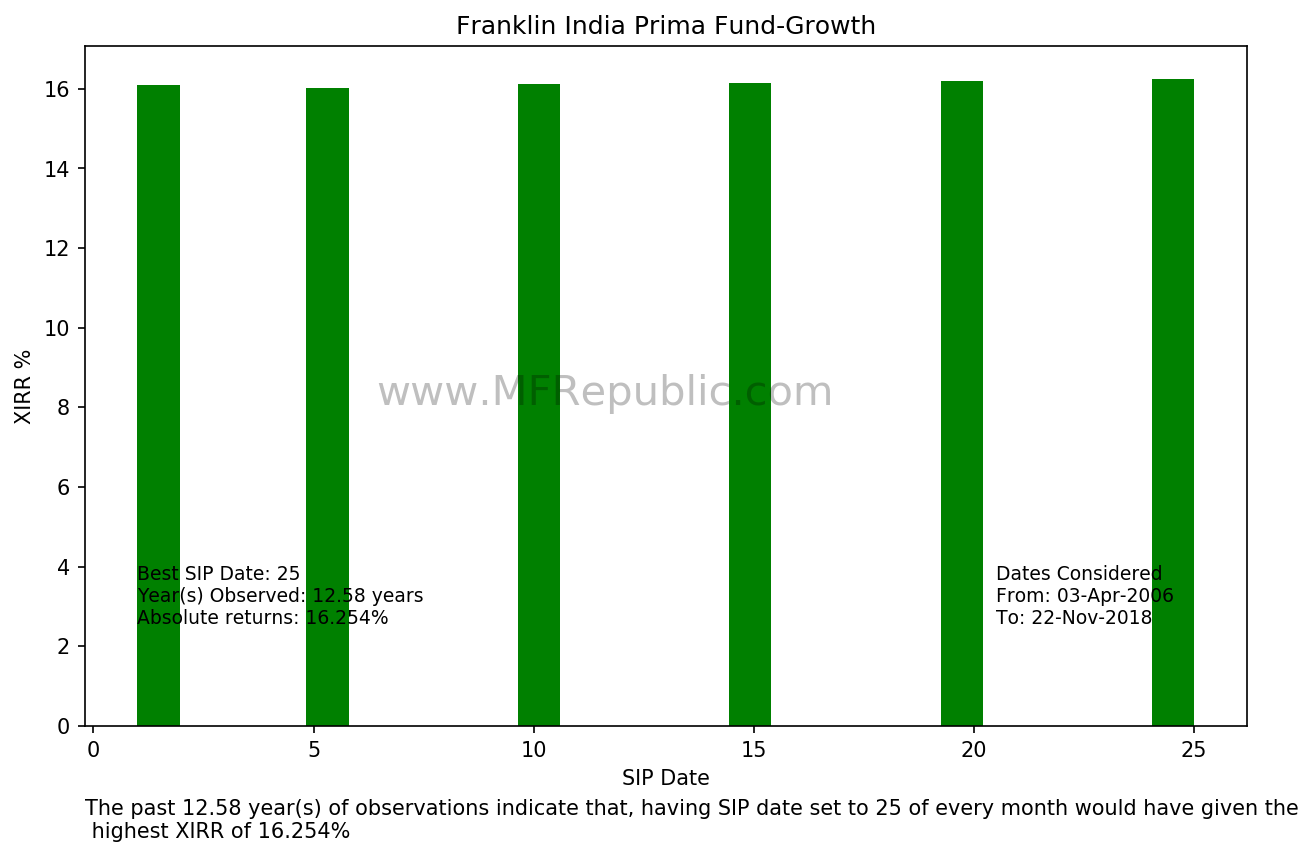

SIP Date,Average Nav,Units,Terms,Amt Invested,Absolute Returns,XIRR %
25,296.6392,2545.1797,151,755000,2266046.025,16.254
20,298.4750,2546.2772,152,760000,2267023.160,16.200
15,298.9525,2542.2098,152,760000,2263401.838,16.148
10,298.6483,2544.7992,152,760000,2265707.255,16.134
1,300.4879,2512.5805,151,755000,2237022.028,16.109
5,300.2884,2530.9001,152,760000,2253332.490,16.027


Investment Made,Best SIP Date,XIRR %
1 Year(s) Ago,20,-6.700
3 Year(s) Ago,25,5.627
5 Year(s) Ago,25,11.990
10 Year(s) Ago,25,18.257
12.58 Year(s) Ago,25,16.254


In [12]:
if __name__ == "__main__":
    isFilterStandardSIPDates = True
    display(HTML('<h1>Best SIP Date for {}</h1>'.format(schemeName)))
    df = loadData(fpath)
    rep = Report(df,isFilterStandardSIPDates)
    Summary(rep)